## Setup

In [1]:
import numpy as np
rng = np.random.default_rng()  
import matplotlib.pylab as plt

## Helpful recources

https://hef.ru.nl/~tbudd/mct/lectures/markov_chain_monte_carlo.html

https://hef.ru.nl/~tbudd/mct/lectures/cluster_algorithms.html

## The 2D Ising model
The Ising model is a classical way of describing ferromagnetism using simplified spin-spin interactions. The 2D version of the Ising model considers an $w$ by $w$ square lattice, resulting in $N=w^2$ spin sites. If the lattice is given periodic boundary conditions, as is conventional, each spin will have exactly 4 neighbouring spins. The energy of the system is then given by

$ E = -J \sum_i \sum_j s_i s_j - \mu H \sum^{N}_{i=1} s_i $

where we sum over all spins $s_i$ and their neighbours $s_j$ with exchange energy $J$, magnetic moment $\mu$, and externally applied magnetic field $H$.

The most interesting variable of the system is the relative magnetisation of the complete lattice 

$M = \frac{1}{N}\sum_i^N s_i$

or the expected total magnetisation

$\mathbb{E}[M(\mathbf{s})]=\sum_{s \in\{-1,1\}^N}M(s) p_{\mathbf{s}}(s)$

with $p_{\mathbf{s}}(s)$ the probability mass function. The magnetisation shows a very strong dependence on the temperature as well as the externally applied magnetic field $H$. The magnetisation can also show a high variance. 

The analytical approach to calculate compute these expected values would be to use the probability mass function 

$p_{\mathbf{s}}(s)=\frac{1}{Z} e^{-\beta E}$

with partition function

$Z=\sum_{s \in\{-1,1\}^N} e^{-\beta E}$

and inverse temperature $\beta = \frac{1}{k_bT}$. However, computing this type of partition function quickly becomes arduous or simply infeasible for a lattice with any interesting number of spins, especially if the variance is also high. We thus typically use computational methods to investigate such systems and estimate the magnetisation $M$.

## A Monte Carlo model
The first steps of making the model will be to construct the lattice and several functions that compute essential properties of the system.

In [25]:
def init_lattice(width,latticeType):
    '''Produce an initial lattice with spins. Type 1 gives all spins 1, type 0 gives a random spins, type -1 gives all spins -1. Captures invalid types.'''
    shape = (width,width)
    if latticeType == 1 or latticeType == -1:
        return np.full(shape,latticeType)
    elif latticeType == 0:
        return rng.integers(0,2,shape)*2-1
    else:
        raise ValueError("Invalid Lattice Type! Accepted values are -1, 0, or 1")

def neighbouring_sites(i,j,width):
    '''Return the coordinates of the 4 sites adjacent to [i,j] on an width*width lattice. Takes into account periodic boundary conditions.'''
    """
    Returns
    -------
    neighbours : list(tuple(int,int))
        List of neighbouring coordinates, formatted as a list of tuples. Order of list goes as:
        
        . . . . .
        . . 0 . .
        . 1 x 2 .
        . . 3 . .
        . . . . .
        
        Where x is the point (i,j)
    """
    li = (i-1) % width
    ri = (i+1) % width
    uj = (j+1) % width
    bj = (j-1) % width
    neighbours = [(i,uj),(li,j),(ri,j),(i,bj)]
    return neighbours

def neighbouring_spins_sum(i,j,lattice,width):
    '''Sums the spins of all neighbours of the spin at [i,j].'''
    neighbours = neighbouring_sites(i,j,width)
    xs,ys = list(zip(*neighbours))
    return np.sum(lattice[xs,ys])

def compute_magnetisation(lattice):
    '''Computes the magnetisation of the lattice.'''
    return np.sum(lattice)/lattice.size

def plot_lattice(lattice,ax,title):
    '''Plot the lattice configuration.'''
    ax.matshow(lattice, vmin=-1, vmax=1, cmap=plt.cm.binary)
    ax.title.set_text(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    
# Unit tests

## init_lattice
testWidth = rng.integers(5,30,1)[0]
assert(np.allclose(init_lattice(testWidth,1), np.full((testWidth,testWidth),1)))
assert(np.allclose(init_lattice(testWidth,-1), np.full((testWidth,testWidth),-1)))
assert(init_lattice(testWidth,0).shape == (testWidth,testWidth))
randomLattice = init_lattice(testWidth,0)
assert(np.count_nonzero((randomLattice == 1) + (randomLattice==-1))==testWidth**2)
#print(randomLattice)

## neighbouring_sites
assert(neighbouring_sites(0,4,6)==[(0,5),(5,4),(1,4),(0,3)])
assert(neighbouring_sites(7,7,8)==[(7,0),(6,7),(0,7),(7,6)])

## neighbouring_spins_sum
width = 5
lattice = np.array([[0 ,1 ,2 ,3 ,4 ],
                    [5 ,6 ,7 ,8 ,9 ],
                    [10,11,12,13,14],
                    [15,16,17,18,19],
                    [20,21,22,23,24]])
assert(neighbouring_spins_sum(0,0,lattice,width)==20+4+1+5)
assert(neighbouring_spins_sum(2,3,lattice,width)==8+12+14+18)
assert(neighbouring_spins_sum(3,4,lattice,width)==15+14+24+18)
assert(neighbouring_spins_sum(1,2,lattice,width)==2+6+8+12)

## compute_magnetisation

assert(np.allclose(compute_magnetisation(lattice),12.))

## The Metropolis-Hastings algorithm
In order to be physically accurate, the transitions rates in our system have to satisfy detailed balance. The Metropolis-Hastings algorithm provides us with a way to select such transition rates without a need for knowing the normalisation of the probability distribution. 

$P(s_i \rightarrow -s_i) = \min \left(1, e^{-(\beta E_{-s_i}-\beta E_{s_i})}\right) = \min \left(1, e^{-\beta \Delta E}\right) = \begin{cases}1 & \text { if } \Delta E \leq 0 \\ e^{-\beta\Delta E} & \text { if } \Delta E > 0 \end{cases}$

where $\Delta E$ is the change in energy of the total lattice.

$\Delta E = 2J s_i \sum_j s_j + 2 \mu H s_i $

With this we can set up way to evolve the system. For convenience, it may be useful to define the interaction energies in terms of $\beta J$ and $\beta \mu H$.

In [109]:
def compute_betaDeltaE(i,j,lattice,width,betaJ,betaMuH):
    '''Computes the energy difference between the old and new state if spin [i,j] would be flipped.'''
    nsum = neighbouring_spins_sum(i,j,lattice,width)
    s_i = lattice[i,j]
    return 2*s_i*(betaJ*nsum+betaMuH)

def attempt_spin_flip(lattice,width,betaJ,betaMuH):
    '''
    Applies the Metropolis-Hastings algorithm to try and flip a spin.
    The proposal distribution is simply picking a random spin and flipping it
    The probability of acceptance is given by P(s_i -> -s_i) above
    
    Returns
    -------
    flipped : bool
        Whether or not the site was successfully flipped
    '''
    # generate two random integers to pick our spin
    i,j = rng.integers(0,width,2)
    betaDeltaE = compute_betaDeltaE(i,j,lattice,width,betaJ,betaMuH)
    Pacc = min(1,np.exp(-betaDeltaE))
    
    # we then generate a random number r uniformly between 0 and 1, and if r < Pacc we accept the attempt
    r = rng.random()
    if r < Pacc:
        # move accepted
        lattice[i,j] *= -1
        return True
    return False
    

def evolve_and_plot(lattice,betaJ,betaMuH,plot_times):
    '''Evolves the lattice using the Metropolis-Hastings algorithm and plots the lattice at different times.'''
    # TO DO
    fig, ax = plt.subplots(1,len(plot_times),figsize=(12,4))
    for t in range(plot_times[-1]+1):
        # attempt a spin flip
        attempt_spin_flip(lattice,width,betaJ,betaMuH)
        
        # plot the lattice if it's a plot time
        if t in plot_times:
            plot_lattice(lattice,ax[plot_times.index(t)],"t = {}".format(t))
    plt.show()

def evolve_and_compute_M(lattice,betaJ,betaMuH,avg_times):
    '''
    Evolves the lattice using the Metropolis-Hastings algorithm and returns the average magnetisation computed using different time steps.
    
    Parameters
    ----------
    lattice : np.array
    betaJ : float
    metaMuH :float
    avg_times : array of ints
        The times to use for the averaging of the magnetisation, in ascending order. The lattice will be evolved avg_times[-1] times, and
        whenever t is an element of avg_times, the magnetisation of the lattice at that time will be included in the average to compute
        the average magnetisation
        
    Returns
    -------
    avgM : float
    '''
    numAvgTimes = len(avg_times)
    numTimeSteps = avg_times[-1]
    
    # avg_times cannot include 0
    if avg_times[0] <= 0:
        raise ValueError("avg_times can only contain times >= 1")
    
    nextAvgTimeIndex = 0
    Msum = 0
    
    for t in range(1,numTimeSteps+1):
        # evolve lattice
        attempt_spin_flip(lattice,width,betaJ,betaMuH)
        
        # for extra time efficiency we only check t against the next largest avg_time
        if t == avg_times[nextAvgTimeIndex]:
            # we add the magnetisation to Msum
            nextAvgTimeIndex += 1
            Msum += compute_magnetisation(lattice)
    
    avgM = Msum / numAvgTimes
    return avgM
            
    

## Testing the model
Evolve the system and plot it at various time steps to see if it appears to behave properly. Let's first get a feel for what a random lattice really looks like. Consider a system with no coupling $\beta J = 0$ and external magnetic field $\beta \mu H = 0$. Try both starting with a random lattice and a lattice with all spins in one direction.

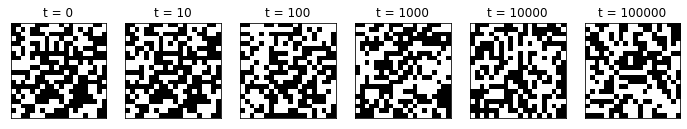

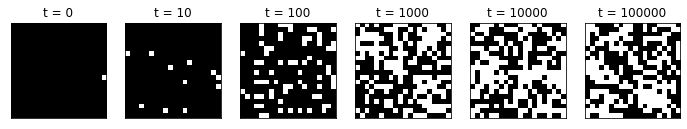

In [33]:
# Testing the Metropolis-Hastings algorithm
plot_times = [0,10,100,1000,10000,100000]

width = 20
lattice = init_lattice(width,0)
evolve_and_plot(lattice,0,0,plot_times)

lattice2 = init_lattice(width,1)
evolve_and_plot(lattice2,0,0,plot_times)

# after many time steps lattice looks random so we're all good - width a width of 20 it takes at least 1000 iterations before we achieve
# a semblence of randomness

## Limiting case 1: only an external field
When $beta J=0$ there is no coupling. In such a case, only thermal motion and the external magnetic field affect the flipping of the spins. Do a few simulations with $-3 < \beta \mu H < 3$ and observe what happends. Again try both starting with a random lattice and a lattice with all spins in one direction. Qualitatively explain the system behaviour.

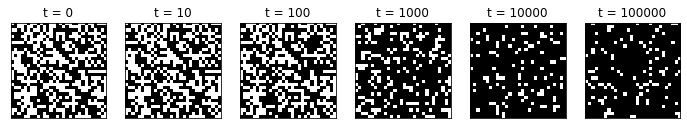

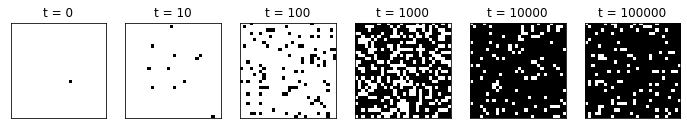

'\nWhen betaMuH is non zero we expect the spins to largely align along the direction of H, but with some random fluctuation.\nThis is exactly what we see. When betaMuH = 3 at large times we get all practically all spins up, and for -3 we get practically all down.\nAs |betaMuH| decreases we get more thermal noise, up until the limit where at betaMuH = 0 we get complete randomness.\nThe thermal noise is uniform as we have turned the coupling of spins off.\n\nThis behaves as we would expect from theory - it is energetically favourable for spins to align with H, but as temperature increases such\nthat kT ~ muH (ie betaMuH ~ 1) we expect thermal fluctuations to start to become significant.\n'

In [46]:
plot_times = [0,10,100,1000,10000,100000]

width = 30
betaJ = 0
betaMuH=1
lattice = init_lattice(width,0)
evolve_and_plot(lattice,betaJ,betaMuH,plot_times)

lattice2 = init_lattice(width,-1)
evolve_and_plot(lattice2,betaJ,betaMuH,plot_times)

"""
When betaMuH is non zero we expect the spins to largely align along the direction of H, but with some random fluctuation.
This is exactly what we see. When betaMuH = 3 at large times we get all practically all spins up, and for -3 we get practically all down.
As |betaMuH| decreases we get more thermal noise, up until the limit where at betaMuH = 0 we get complete randomness.
The thermal noise is uniform as we have turned the coupling of spins off.

This behaves as we would expect from theory - it is energetically favourable for spins to align with H, but as temperature increases such
that kT ~ muH (ie betaMuH ~ 1) we expect thermal fluctuations to start to become significant.
"""

In the case of no coupling, an analytical expression for the mean magnetisation $\langle M\rangle$ exists. The expression is:

$\langle M\rangle = \tanh \left(\beta \mu H \right)$

Show that the Monte Carlo method correctly repoduces the above analytical formula.

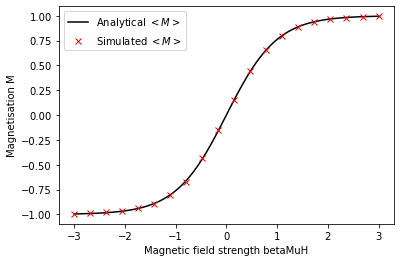

'\nWe get great agreement between the analytical expression and the simulated magnetisation\n'

In [58]:
betaMuHs_analytical = np.linspace(-3,3,100) # betaMuH values to plot
M_analytical = np.tanh(betaMuHs_analytical)

betaJ = 0

# we'll use a width of 20, and we know from our testing above that the lattice equilibrises within 1000 timesteps, so averaging every 1000
# times will be suitable. We take 50 points to average for a total of 50,000 timesteps
avg_times = np.arange(1000,50001,1000)

# for the sake of time we'll only do 20 values of betaMuH
betaMuHs_simulated = np.linspace(-3,3,20)
width = 20
M_sim = []
for betaMuH in betaMuHs_simulated:
    lattice = init_lattice(width,0)
    M_sim.append(evolve_and_compute_M(lattice,betaJ,betaMuH,avg_times))
    
plt.plot(betaMuHs_analytical,M_analytical,"k-",label="Analytical $<M>$")
plt.plot(betaMuHs_simulated,M_sim,"rx",label="Simulated $<M>$")

plt.xlabel ('Magnetic field strength betaMuH')
plt.ylabel ('Magnetisation M')
plt.legend(loc='upper left')
plt.show()

"""
We get great agreement between the analytical expression and the simulated magnetisation
"""

## Limiting case 2: only coupling

Now let us investigate coupling without an external magnetic field. Try the same as previously, using different starting conditions, but introduce some ferromagnetic coupling ($\beta J = 0.2$) or anti-ferromagnetic coupling ($\beta J = -0.2$). Qualitatively explain the system behaviour.

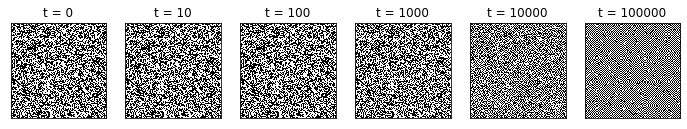

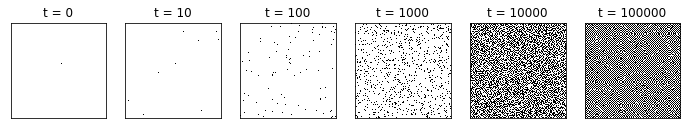

"\nFor betaJ=0.2: Now when we see randomness in the spins, they're clumped up, as expected from the fact that adjacent spins are preferentially aligned.\nIf we increase betaJ to 0.3 we see even more clumping. Now it takes ~10000 timesteps to reach equilibrium for a width of 20\n\nFor betaJ = -0.2 (antiferromagnetic) we expect to see something like a checkerboard pattern as spins want to be antialigned with their neighbours.\nWe can see regions of this occuring, but random thermal perturbations stop the phase being ordered for betaJ=-0.2.\nIf we make betaJ even smaller, for example -1, we can see much more clearly the ordered checkerboard phase, with some anti-phase boundaries\nthrough the lattice\n"

In [110]:
plot_times = [0,10,100,1000,10000,100000]

width = 100
betaJ = -1
betaMuH = 0
lattice = init_lattice(width,0)
evolve_and_plot(lattice,betaJ,betaMuH,plot_times)

lattice2 = init_lattice(width,-1)
evolve_and_plot(lattice2,betaJ,betaMuH,plot_times)

"""
For betaJ=0.2: Now when we see randomness in the spins, they're clumped up, as expected from the fact that adjacent spins are preferentially aligned.
If we increase betaJ to 0.3 we see even more clumping. Now it takes ~10000 timesteps to reach equilibrium for a width of 20

For betaJ = -0.2 (antiferromagnetic) we expect to see something like a checkerboard pattern as spins want to be antialigned with their neighbours.
We can see regions of this occuring, but random thermal perturbations stop the phase being ordered for betaJ=-0.2.
If we make betaJ even smaller, for example -1, we can see much more clearly the ordered checkerboard phase, with some anti-phase boundaries
through the lattice
"""

Also for this case, no field and only coupling, Lars Onsanger discovered an analytical solution:

$\langle M\rangle= \begin{cases}0 & \text { if } T \geq T_c \\ \pm \left(1-\sinh \left(2 \beta J\right)^{-4}\right)^{\frac{1}{8}} & \text { if } T<T_c\end{cases}$

where $T_c$ is the critical temperature given by

$T_c=\frac{2 J}{k_b \ln (1+\sqrt{2})}$

Show again that the Monte Carlo method correctly repoduces the above analytical formula. What do you notice about the system around the critical point?

Hint: The system will equilibrate much faster if you start with an initial state that is close to the expected final state.

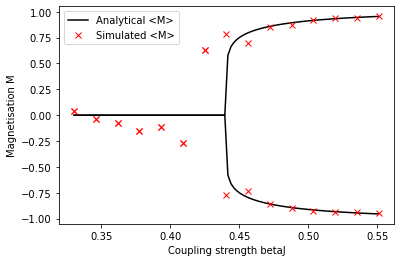

In [74]:
betaMuH = 0
# critical value of betaJ = ln(1+sqrt(2)/2 = 0.44
betaJcrit = np.log(1+np.sqrt(2))/2
# if betaJ is larger than this T<T_c
# if betaJ is smaller T>T_c

# define range of betaJs to test
minBetaJ = betaJcrit*0.75
maxBetaJ = betaJcrit*1.25
betaJanalytical = np.linspace(minBetaJ,maxBetaJ,100)

# calculate the analytical magnetisation
def analyticalCouplingMPlus(betaJ):
    if betaJ <= betaJcrit:
        # T > T_c
        return 0
    else:
        return (1-np.sinh(2*betaJ)**(-4))**(1/8)
    
def analyticalCouplingMMinus(betaJ):
    if betaJ <= betaJcrit:
        # T > T_c
        return 0
    else:
        # T < T_c
        return -(1-np.sinh(2*betaJ)**(-4))**(1/8)

# I tried vectorizing these functions but numpy didn't like them for some reason

analyticalMPlus = np.array([analyticalCouplingMPlus(betaJ) for betaJ in betaJanalytical])
analyticalMMinus = np.array([analyticalCouplingMMinus(betaJ) for betaJ in betaJanalytical])


# Simuatle the system at different coupling strengths

betaJsim = np.linspace(minBetaJ,maxBetaJ,15)
simMPlus = []
simMMinus = []
width = 20
avg_times = np.arange(5000,70001,1000)
# avg_times = np.arange(100,500,100)
for betaJ in betaJsim:
    # we force the lattice to start either all spin up or spin down once we're
    # higher than betaJ so that we can find the equilibrium faster
    if betaJ < betaJcrit:
        lattice = init_lattice(width,0)
        avgM = evolve_and_compute_M(lattice,betaJ,betaMuH,avg_times)
        simMPlus.append(avgM)
        simMMinus.append(avgM)
    else:
        # do first starting with all spins up
        lattice = init_lattice(width,1)
        avgM = evolve_and_compute_M(lattice,betaJ,betaMuH,avg_times)
        simMPlus.append(avgM)
        
        # do again starting with all spins down
        lattice = init_lattice(width,-1)
        avgM = evolve_and_compute_M(lattice,betaJ,betaMuH,avg_times)
        simMMinus.append(avgM)

# Plot

plt.plot(betaJanalytical,analyticalMPlus,"k-")
plt.plot(betaJanalytical,analyticalMMinus,"k-",label="Analytical <M>")

plt.plot(betaJsim,simMMinus,"rx",label="Simulated <M>")
plt.plot(betaJsim,simMPlus,"rx")

plt.xlabel ('Coupling strength betaJ')

plt.ylabel ('Magnetisation M')
plt.legend(loc='upper left')
plt.show()

In [75]:
"""
We get decent agreement away from the critical point, but close to the critical point we get large fluctuations. This is to be expected from
the thermodynamics - as a critical point is approached, the fluctuations in the order parameter diverge.
"""

'\nWe get decent agreement away from the critical point, but close to the critical point we get large fluctuations. This is to be expected from\nthe thermodynamics - as a critical point is approached, the fluctuations in the order parameter diverge.\n'

## Optional: implement the Wolff algorithm
**One more non-optional exercise after this, please look ahead.** In some cases, as you might realise in the next exercise, it can take quite long for the Metropolis-Hastings algorithm to sample the state space of the system. The Wolff algorithm was developed to speed up the exploration of the state space by flipping multiple spins (of the same sign) at once.

The algorithm works as follows:

- Select a spin $s_i$ at random

- Start checking all neighbouring spins $s_j$

- Add a neighbouring spin $s_j$ to the cluster with probability $P_{add} = 1-\exp(-\beta \Delta E)$, but only if it has the same sign as $s_i$

- Repeat until no unvisited neighbours remain

- Flip all spins

Implement Wolff algorithm and compare the equilibration speed to that of the Metropolis-Hastings algorithm for a system with only coupling ($\beta J=0.2$). Hint: In practice it is more convenient to already flip all visited spins.

For the interested reader, an even more efficient method is the Swendsen-Wang algorithm (https://en.wikipedia.org/wiki/Swendsen%E2%80%93Wang_algorithm).

In [9]:
def spin_flip_wolff(lattice,width,betaJ,betaMuH):
    '''Applies the Wolff algorithm to try and flip a spin.'''
    i,j = rng.integers(0,width,2) # Select a random seed
    # TO DO
    unvisited = # TO DO
    while (len(unvisited)>0):   # while unvisited sites remain
        i,j = unvisited.pop(0)  # take one and remove from the unvisited list
        for x,y in neighbouring_sites(i,j,width):
            # TO DO
    return cluster_size

def evolve_and_plot_wolff(lattice,betaJ,betaMuH,plot_times):
    '''Evolves the lattice using the Wolff algorithm and plots the lattice at different times.'''
    # TO DO
    fig, ax = plt.subplots(1,len(plot_times),figsize=(12,4))
    for t in range(plot_times[-1]+1):
        # TO DO
        if t in plot_times:
            plot_lattice(lattice,ax[plot_times.index(t)],"t = {}".format(t))
    plt.show()

In [ ]:
# Testing the Wolff algorithm if it has been implemented

# TO DO

## Mandatory: Magnetic susceptibility
A common problem in physical simulations is that we are limited in the size of the systems that we can simulate within a reasonable time. Periodic boundary conditions are typically a good way of circumventing problems caused by finite systems, but some problems cannot be circumvented that easily. The magnetisation of the 2D Ising model shows a continuous phase transition, and statistical physics tells us the correlation length $\xi$ of the system thus follows the relation

$\xi \sim\left|T-T_c\right|^{-\nu}$

with $\nu$ is called the critical exponent. This means that the correlation length will quickly diverge near the critical point and correlate most, if not all, spins in the system with each other. This strongly affects the magnetic susceptibility $\chi$ that is defined as

$\chi=\frac{1}{N} \frac{\partial M}{\partial H}=\frac{\beta}{N}\left(\left\langle M^2\right\rangle-\langle M \rangle^2\right)$.

Run a number of tests to see how the magnetic susceptibility $\chi$ changes as the critical temperature of the system is approached. Repeat this for a smaller or larger lattice. What does this tell you about our ability to get accurate average properties for the system near the critical temperature?

Note: It is more convenient to use the definition of magnetic susceptibility that uses the variance of the magnetisation than the definition of the gradient w.r.t. the magnetic field.

In [77]:
def evolve_and_computeChi(lattice,beta,J,MuH,avg_times):
    '''
    Evolves the lattice using the Metropolis-Hastings algorithm and returns the magnetic susceptibility computed using different time steps.
    
    Parameters
    ----------
    lattice : np.array
    beta : float
    J : float
    MuH : float
    avg_times : array of ints
        The times to use for the averaging of the magnetisation, in ascending order. The lattice will be evolved avg_times[-1] times, and
        whenever t is an element of avg_times, the magnetisation of the lattice at that time will be included in the average to compute
        the average magnetisation
        
    Returns
    -------
    chi : float
    '''
    betaJ = beta * J
    betaMuH = beta * MuH
    numAvgTimes = len(avg_times)
    numTimeSteps = avg_times[-1]
    
    # avg_times cannot include 0
    if avg_times[0] <= 0:
        raise ValueError("avg_times can only contain times >= 1")
    
    nextAvgTimeIndex = 0
    Ms = []
    
    for t in range(1,numTimeSteps+1):
        # evolve lattice
        attempt_spin_flip(lattice,width,betaJ,betaMuH)
        
        # for extra time efficiency we only check t against the next largest avg_time
        if t == avg_times[nextAvgTimeIndex]:
            # we add the magnetisation to Msum
            nextAvgTimeIndex += 1
            Ms.append(compute_magnetisation(lattice))
    
    Ms = np.array(Ms)
    # I don't think there should be 1 / N in this formula so I'm not going to put one there
    chi = beta * np.var(Ms)
    
    return chi

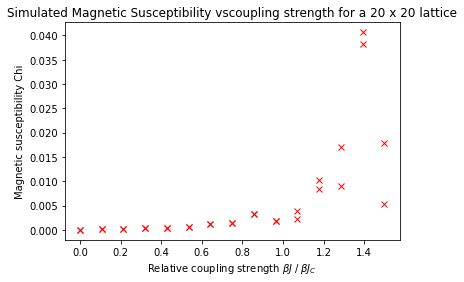

In [89]:
# Simulate the system at different coupling strengths (relative to the critical temperature)

# we set betaMuH to 0 to get zero field susceptibility
betaMuH = 0
# we also set a value for J so that we can compute beta (necessary to get chi)
J = 1

# critical value of betaJ = ln(1+sqrt(2)/2 = 0.44
betaJcrit = np.log(1+np.sqrt(2))/2
# if betaJ is larger than this T<T_c
# if betaJ is smaller T>T_c

# define range of betaJs to test
minBetaJ = betaJcrit*0
maxBetaJ = betaJcrit*1.5
betaJanalytical = np.linspace(minBetaJ,maxBetaJ,100)

betaJsim = np.linspace(minBetaJ,maxBetaJ,15)
simChiPlus = []
simChiMinus = []
width = 20
avg_times = np.arange(10000,80001,2000)
# avg_times = np.arange(100,500,100)
for betaJ in betaJsim:
    # get beta from betaJ and J
    beta = betaJ/J
    
    # we force the lattice to start either all spin up or spin down once we're
    # higher than betaJ so that we can find the equilibrium faster
    if betaJ < betaJcrit:
        # random lattice
        lattice = init_lattice(width,0)
        chi = evolve_and_computeChi(lattice,beta,betaJ,betaMuH,avg_times)
        simChiPlus.append(chi)
        simChiMinus.append(chi)
    else:
        # do first starting with all spins up
        lattice = init_lattice(width,1)
        chi = evolve_and_computeChi(lattice,beta,betaJ,betaMuH,avg_times)
        simChiPlus.append(chi)
        
        # do again starting with all spins down
        lattice = init_lattice(width,-1)
        chi = evolve_and_computeChi(lattice,beta,betaJ,betaMuH,avg_times)
        simChiMinus.append(chi)

# Plot

plt.plot(betaJsim/betaJcrit,simChiMinus,"rx",label="Simulated <$\\chi$>")
plt.plot(betaJsim/betaJcrit,simChiPlus,"rx")

plt.title("Simulated Magnetic Susceptibility vscoupling strength for a 20 x 20 lattice")
plt.xlabel('Relative coupling strength $\\beta J \\; / \\; \\beta J_C$')
plt.ylabel('Magnetic susceptibility Chi')
plt.show()

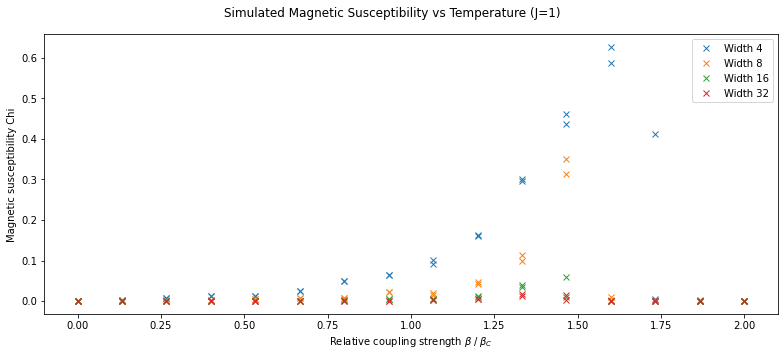

In [108]:
# Smaller or larger lattice to show susceptibility changes

# we set betaMuH to 0 to get zero field susceptibility
betaMuH = 0
# we also set a value for J so that we can compute beta (necessary to get chi)
J = 1

# critical value of betaJ = ln(1+sqrt(2)/2 = 0.44
betaJcrit = np.log(1+np.sqrt(2))/2
# if betaJ is larger than this T<T_c
# if betaJ is smaller T>T_c

# define range of betaJs to test
minBetaJ = betaJcrit*0
maxBetaJ = betaJcrit*2
betaJanalytical = np.linspace(minBetaJ,maxBetaJ,100)

betaJsim = np.linspace(minBetaJ,maxBetaJ,16)
avg_times = np.arange(5000,50001,1000)
# avg_times = np.arange(100,500,100)

# don't want to go as high as 64 because then we can't average every 1000 (32^2 ~ 1000)
# can't take larger timesteps because this code already takes very long to run
widths = [4,8,16,32]

# set up plots
fig, ax = plt.subplots(1,1,figsize=(11,5))

for width in widths:
    simChiPlus = []
    simChiMinus = []
    for betaJ in betaJsim:
        # get beta from betaJ and J
        beta = betaJ/J

        # we force the lattice to start either all spin up or spin down once we're
        # higher than betaJ so that we can find the equilibrium faster
        if betaJ < betaJcrit:
            # random lattice
            lattice = init_lattice(width,0)
            chi = evolve_and_computeChi(lattice,beta,betaJ,betaMuH,avg_times)
            simChiPlus.append(chi)
            simChiMinus.append(chi)
        else:
            # do first starting with all spins up
            lattice = init_lattice(width,1)
            chi = evolve_and_computeChi(lattice,beta,betaJ,betaMuH,avg_times)
            simChiPlus.append(chi)

            # do again starting with all spins down
            lattice = init_lattice(width,-1)
            chi = evolve_and_computeChi(lattice,beta,betaJ,betaMuH,avg_times)
            simChiMinus.append(chi)

    # plot

    p = ax.plot(betaJsim/betaJcrit,simChiMinus,marker="x",ls="",label="Width {0}".format(width))
    ax.plot(betaJsim/betaJcrit,simChiPlus,marker="x",ls="",c=p[0].get_color())

fig.suptitle("Simulated Magnetic Susceptibility vs Temperature (J=1)")
ax.set_xlabel('Relative coupling strength $\\beta \\; / \\; \\beta_C$')
ax.set_ylabel('Magnetic susceptibility Chi')
ax.legend()
plt.tight_layout()
plt.show()

In [107]:
"""
From the plot above, for small lattices we get very large fluctuations in chi once under the critical temperature. Interestingly, these fluctuations
don't seem to happen *at* the critical temperature, rather slightly below. This shows us that to be able to get average
properties of a system close to its critical temperature, we need to have large simulations, which then require a larger number of time steps to reach
equilibrium.
"""

"\nFrom the plot above, for small lattices we get very large fluctuations in chi once under the critical temperature. Interestingly, these fluctuations\ndon't seem to happen *at* the critical temperature, rather slightly below. This shows us that to be able to get average\nproperties of a system close to its critical temperature, we need to have large simulations, which then require a larger number of time steps to reach\nequilibrium.\n"

## Optional: Further assignments

**Investigate finite-size scaling of the lattice.** The critical temperature varies as a function of the lattice size $N=w*w$

$T_c(N) = T_c(\infty)+aN^{-1/b}$

with $a$ and $b$ being constants to estimate. Compare your estimated $T_c(\infty)$ to Onsanger's analytical result.

**Compute the decorrelation time of the magnetisation to determine the proper equilibration time.** The autovariance is defined as

$A(\tau)=\langle M'(t)M'(t+\tau) \rangle$

where $M'=M-\langle M \rangle$ and $\tau$ is the lag time. The autocorrelation is then given by $a(\tau)=\frac{A(\tau)}{A(0)}$. The decorrelation time can them be said to be $\tau$ for which $a(\tau)$ has dropped to $1/e$.

**Determine the heat capacity.** The fluctuation dissipation theorem states that the heat capacity of the system is given by

$C=\frac{\sigma_E}{k_B T^2} $

with $\sigma_E$ being the standard deviation in the system energy.